1. Mount Drive & Extract Data

In [5]:
from google.colab import drive
drive.mount('/content/drive')

!mkdir -p /content/drive/MyDrive/segmentation_dataset
!unzip -q "/content/drive/MyDrive/roboflow_segmentation.zip" -d "/content/drive/MyDrive/segmentation_dataset"


Mounted at /content/drive
replace /content/drive/MyDrive/segmentation_dataset/README.dataset.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


2. Verify Data Structure

In [6]:
import os
print(os.listdir("/content/drive/MyDrive/segmentation_dataset")[:20])

BASE_DIR = "/content/drive/MyDrive/segmentation_dataset"
for root, dirs, files in os.walk(BASE_DIR):
    level = root.replace(BASE_DIR, "").count(os.sep)
    indent = " " * 2 * (level)
    print(f"{indent}{os.path.basename(root)}/")
    subindent = " " * 2 * (level + 1)
    for f in files[:5]:
        print(f"{subindent}{f}")

['valid', 'train', 'test', 'README.dataset.txt', 'README.roboflow.txt']
segmentation_dataset/
  README.dataset.txt
  README.roboflow.txt
  valid/
    _classes.csv
    flight_record_20250824_100909_000005_jpg.rf.5ae73dc646f61da2b7829f078517744d.jpg
    flight_record_20250824_100909_000001_jpg.rf.e0f73fb16fdcc108f87adb52ac65eeb8.jpg
    flight_record_20250824_100909_000001_jpg.rf.e0f73fb16fdcc108f87adb52ac65eeb8_mask.png
    flight_record_20250824_100909_000005_jpg.rf.5ae73dc646f61da2b7829f078517744d_mask.png
  train/
    _classes.csv
    flight_record_20250824_100909_000000_jpg.rf.72c7bb8fd48b08f23fa274410b37f42a.jpg
    flight_record_20250824_100909_000000_jpg.rf.72c7bb8fd48b08f23fa274410b37f42a_mask.png
    flight_record_20250824_100909_000002_jpg.rf.d048ee59a65f0da4f54caa94f4762996.jpg
    flight_record_20250824_100909_000002_jpg.rf.d048ee59a65f0da4f54caa94f4762996_mask.png
  test/
    flight_record_20250824_100909_000591_jpg.rf.3cdab24c867e8b77b83223885e813195_mask.png
    flight_re

3. Load Image/Mask Pairs

In [7]:
import glob

def load_pairs(split):
    img_files = sorted(glob.glob(os.path.join(BASE_DIR, split, "*.jpg")))
    pairs = []
    for img in img_files:
        mask = img.replace(".jpg", "_mask.png")
        if os.path.exists(mask):
            pairs.append((img, mask))
    return pairs

train_pairs = load_pairs("train")
val_pairs   = load_pairs("valid")
test_pairs  = load_pairs("test")

print("Train pairs:", len(train_pairs))
print("Valid pairs:", len(val_pairs))
print("Test pairs :", len(test_pairs))
print("Example train pair:\n", train_pairs[0])

Train pairs: 72
Valid pairs: 17
Test pairs : 10
Example train pair:
 ('/content/drive/MyDrive/segmentation_dataset/train/flight_record_20250824_100909_000000_jpg.rf.72c7bb8fd48b08f23fa274410b37f42a.jpg', '/content/drive/MyDrive/segmentation_dataset/train/flight_record_20250824_100909_000000_jpg.rf.72c7bb8fd48b08f23fa274410b37f42a_mask.png')


4. Dataset + Augmentation

In [8]:
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2

HEIGHT, WIDTH = 320, 320

train_transform = A.Compose([
    A.Resize(HEIGHT, WIDTH),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.RandomRotate90(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
], is_check_shapes=False)

val_transform = A.Compose([
    A.Resize(HEIGHT, WIDTH),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
], is_check_shapes=False)

class DroneSegDataset(Dataset):
    def __init__(self, pairs, transform=None):
        self.pairs = pairs
        self.transform = transform

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_path, mask_path = self.pairs[idx]

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE).astype('int64')

        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented["image"]
            mask = augmented["mask"]

        return img, mask.long()


train_ds = DroneSegDataset(train_pairs, transform=train_transform)
val_ds   = DroneSegDataset(val_pairs, transform=val_transform)

print("Train size:", len(train_ds))
print("Val size:", len(val_ds))
img, mask = train_ds[0]
print("Image shape:", img.shape)
print("Mask shape:", mask.shape, "Unique values:", mask.unique())


Train size: 72
Val size: 17
Image shape: torch.Size([3, 320, 320])
Mask shape: torch.Size([320, 320]) Unique values: tensor([0, 1, 2])


 5. DataLoader

In [9]:
from torch.utils.data import DataLoader

BATCH_SIZE = 8
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

for images, masks in train_loader:
    print("Batch image shape:", images.shape)
    print("Batch mask shape :", masks.shape)
    break

Batch image shape: torch.Size([8, 3, 320, 320])
Batch mask shape : torch.Size([8, 320, 320])


6. Install Segmentation Models

In [10]:
!pip install -q segmentation-models-pytorch --extra-index-url https://download.pytorch.org/whl/cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 6.3 MB/s eta 0:00:00


7. Define Model + Loss

In [11]:
import torch.nn as nn
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = smp.Unet(
    encoder_name="mobilenet_v2",
    encoder_weights="imagenet",
    in_channels=3,
    classes=3,  # background, path, road
    activation=None
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=3)

Using device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/14.2M [00:00<?, ?B/s]

8. Multi-class Dice Score

In [12]:
def multiclass_dice_score(preds, targets, num_classes=3):
    preds = torch.argmax(preds, dim=1)  # [B,H,W]
    dice = 0.0
    for cls in range(num_classes):
        pred_cls = (preds == cls).float()
        target_cls = (targets == cls).float()
        intersection = (pred_cls * target_cls).sum()
        union = pred_cls.sum() + target_cls.sum()
        if union == 0:
            continue
        dice += (2. * intersection) / (union + 1e-6)
    return dice / num_classes

9. Training & Validation

In [13]:
def train_one_epoch(model, loader, optimizer):
    model.train()
    total_loss = 0
    for images, masks in loader:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(loader)

def validate(model, loader):
    model.eval()
    total_loss, total_dice = 0, 0
    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)

            loss = criterion(outputs, masks)
            total_loss += loss.item()

            dice = multiclass_dice_score(outputs, masks)
            total_dice += dice.item()

    return total_loss / len(loader), total_dice / len(loader)

10. Training Loop

In [14]:
EPOCHS = 50
best_dice = 0.0

for epoch in range(1, EPOCHS + 1):
    train_loss = train_one_epoch(model, train_loader, optimizer)
    val_loss, val_dice = validate(model, val_loader)

    scheduler.step(val_dice)

    print(f"Epoch [{epoch}/{EPOCHS}] "
          f"Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | "
          f"Val Dice: {val_dice:.4f}")

    if val_dice > best_dice:
        best_dice = val_dice
        save_path = "/content/drive/MyDrive/best_segmentation_model.pth"
        torch.save(model.state_dict(), save_path)
        print(f"✅ Model saved at {save_path}")
        print("✅ Saved new best model")

print("Training finished! Best Dice score:", best_dice)


Epoch [1/50] Train Loss: 0.8157 | Val Loss: 0.7111 | Val Dice: 0.6053
✅ Model saved at /content/drive/MyDrive/best_segmentation_model.pth
✅ Saved new best model
Epoch [2/50] Train Loss: 0.3141 | Val Loss: 0.2886 | Val Dice: 0.8679
✅ Model saved at /content/drive/MyDrive/best_segmentation_model.pth
✅ Saved new best model
Epoch [3/50] Train Loss: 0.1557 | Val Loss: 0.1482 | Val Dice: 0.9240
✅ Model saved at /content/drive/MyDrive/best_segmentation_model.pth
✅ Saved new best model
Epoch [4/50] Train Loss: 0.0984 | Val Loss: 0.1063 | Val Dice: 0.9466
✅ Model saved at /content/drive/MyDrive/best_segmentation_model.pth
✅ Saved new best model
Epoch [5/50] Train Loss: 0.0764 | Val Loss: 0.0823 | Val Dice: 0.9535
✅ Model saved at /content/drive/MyDrive/best_segmentation_model.pth
✅ Saved new best model
Epoch [6/50] Train Loss: 0.0642 | Val Loss: 0.0700 | Val Dice: 0.9575
✅ Model saved at /content/drive/MyDrive/best_segmentation_model.pth
✅ Saved new best model
Epoch [7/50] Train Loss: 0.0573 | 

11. Visualization

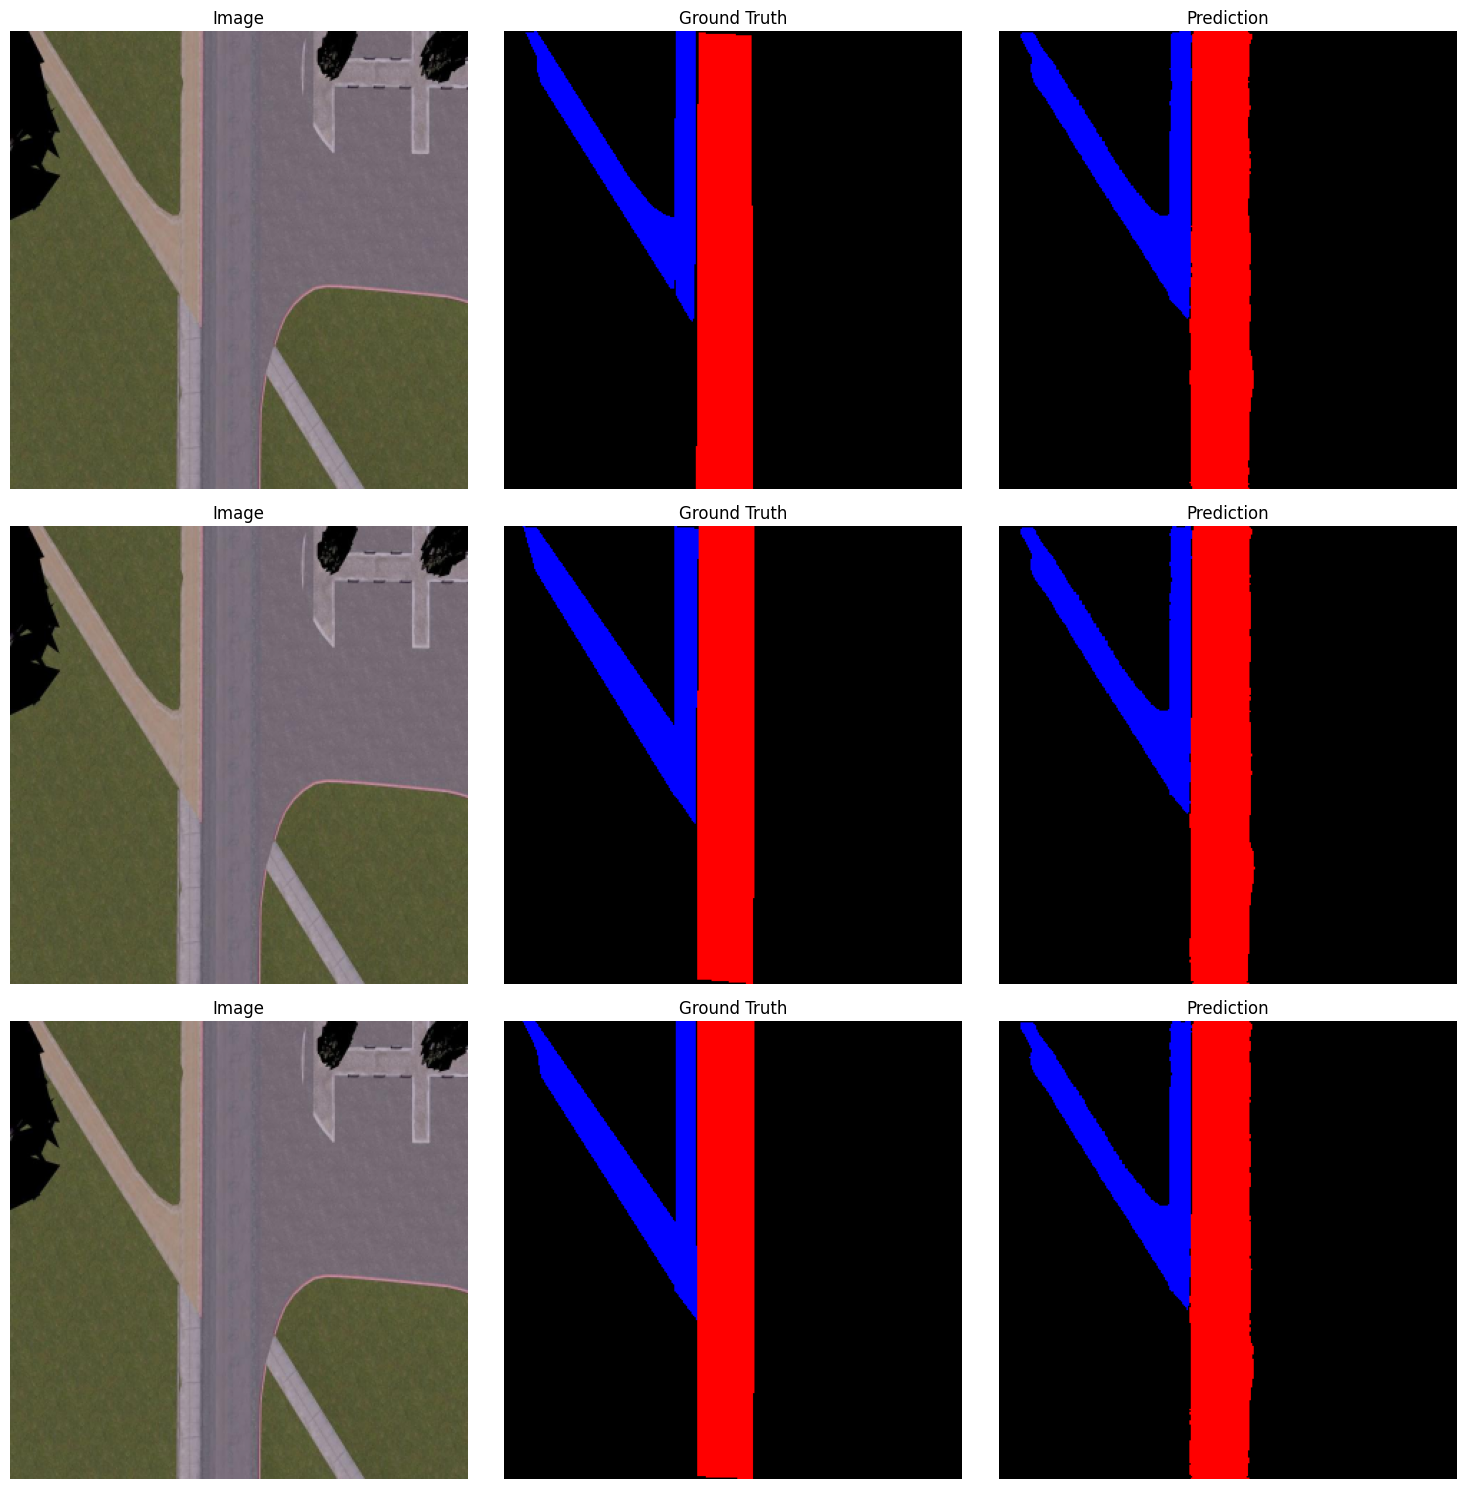

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Load best model
model.load_state_dict(torch.load(save_path))
model.eval()

# Class colors (background=black, path=blue, road=red for example)
COLORS = {
    0: (0, 0, 0),       # background
    1: (0, 0, 255),     # path
    2: (255, 0, 0)      # road
}

def decode_segmap(mask):
    """Convert mask with class indices to RGB image"""
    h, w = mask.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for cls, color in COLORS.items():
        color_mask[mask == cls] = color
    return color_mask

def visualize_predictions(dataset, num_samples=3):
    plt.figure(figsize=(15, num_samples * 5))
    for i in range(num_samples):
        img, mask = dataset[i]
        img_in = img.unsqueeze(0).to(device)

        with torch.no_grad():
            pred = model(img_in)
            pred = torch.argmax(pred, dim=1)[0].cpu().numpy()  # [H,W]

        img_np = img.permute(1, 2, 0).cpu().numpy()
        mask_np = mask.cpu().numpy()  # [H,W]

        # denormalize for display
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img_np = (img_np * std + mean).clip(0, 1)

        # decode masks into RGB colors
        mask_rgb = decode_segmap(mask_np)
        pred_rgb = decode_segmap(pred)

        # plot
        plt.subplot(num_samples, 3, i*3+1)
        plt.imshow(img_np)
        plt.title("Image"); plt.axis("off")

        plt.subplot(num_samples, 3, i*3+2)
        plt.imshow(mask_rgb)
        plt.title("Ground Truth"); plt.axis("off")

        plt.subplot(num_samples, 3, i*3+3)
        plt.imshow(pred_rgb)
        plt.title("Prediction"); plt.axis("off")

    plt.tight_layout()
    plt.show()

# Run on validation set
visualize_predictions(val_ds, num_samples=3)
